# Pair Trading with Engle–Granger Cointegration

This notebook demonstrates a simple pairs-trading strategy:
- Generate two (cointegrated) price series  
- Test for cointegration (Engle–Granger)  
- Compute hedge ratio, spread & z-score  
- Generate entry/exit signals  
- Simulate P&L  
- Plot prices, spread/z-score, and cumulative P&L

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# For reproducibility
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Generate Synthetic Price Series
We create:
- `S1` as a random walk  
- `S2` as a linear function of `S1` plus small noise

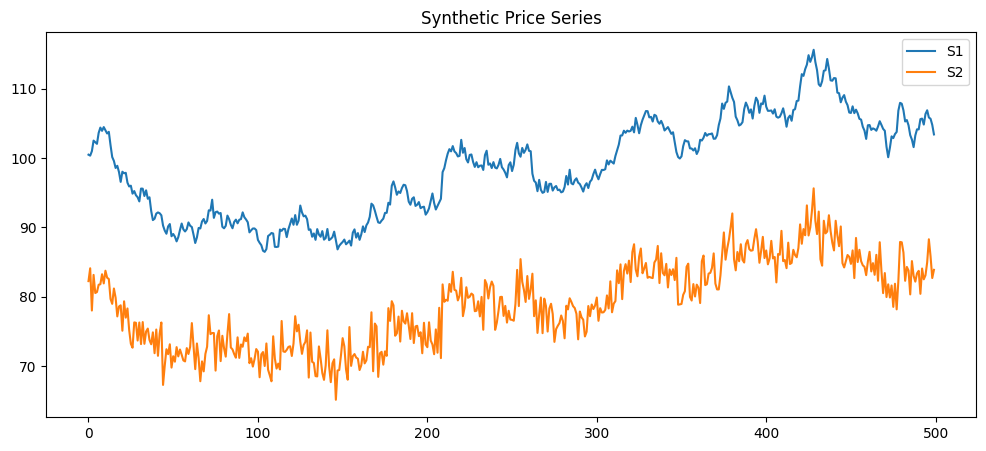

In [2]:
n = 500
t = np.arange(n)

# Random walk for S1
eps1 = np.random.normal(scale=1.0, size=n)
S1 = 100 + np.cumsum(eps1)

# S2 = 0.8 * S1 + noise
beta_true = 0.8
eps2 = np.random.normal(scale=2.0, size=n)
S2 = beta_true * S1 + eps2

# Put into DataFrame
df = pd.DataFrame({'S1': S1, 'S2': S2})
df.plot(title="Synthetic Price Series")
plt.show()

## 2. Engle–Granger Cointegration Test
Test the null hypothesis of *no* cointegration. A low p-value (<0.05) indicates cointegration.

In [3]:
score, pvalue, _ = coint(df['S1'], df['S2'])
print(f"Engle–Granger test p-value = {pvalue:.4f}")

Engle–Granger test p-value = 0.0019


## 3. Estimate Hedge Ratio & Compute Spread
Run a regression of `S2` on `S1` to get the hedge ratio β̂.  
Then define the spread:  
\[spread_t = S2_t - β̂ \times S1_t\] and compute its z-score.

Estimated hedge ratio β̂ = 0.8130


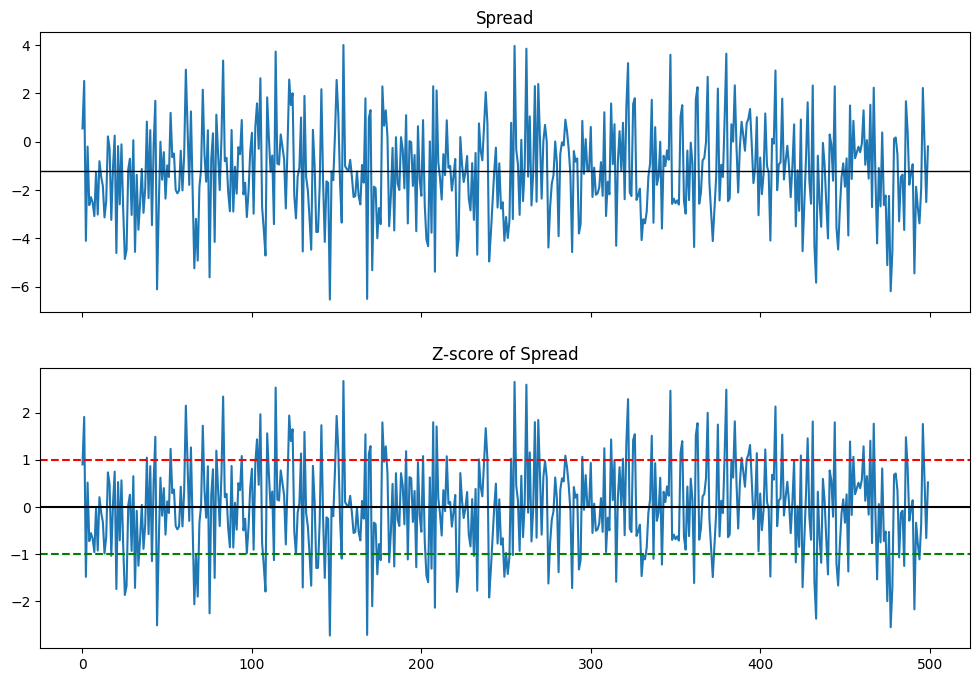

In [4]:
X = sm.add_constant(df['S1'])
model = sm.OLS(df['S2'], X).fit()
beta_hat = model.params['S1']
print(f"Estimated hedge ratio β̂ = {beta_hat:.4f}")

# Spread and z-score
df['spread'] = df['S2'] - beta_hat * df['S1']
df['zscore'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()

# Plot spread & z-score
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))
df['spread'].plot(ax=axes[0], title='Spread')
axes[0].axhline(df['spread'].mean(), color='black', lw=1)
df['zscore'].plot(ax=axes[1], title='Z-score of Spread')
axes[1].axhline( 1.0, color='red', linestyle='--')
axes[1].axhline(-1.0, color='green', linestyle='--')
axes[1].axhline( 0.0, color='black', linestyle='-')
plt.show()

## 4. Generate Trading Signals
- **Enter long spread** when z < –1 (long S2, short β̂·S1)  
- **Enter short spread** when z > +1 (short S2, long β̂·S1)  
- **Exit** when |z| < 0

In [5]:
entry_z, exit_z = 1.0, 0.0

# Signal columns
df['long_spread']  = (df['zscore'] < -entry_z).astype(int)
df['short_spread'] = (df['zscore'] >  entry_z).astype(int)

# Position: +1 long spread, -1 short spread, 0 flat
df['position'] = 0
pos = 0
for i in range(len(df)):
    if pos == 0:
        if df['long_spread'].iloc[i]: pos = +1
        elif df['short_spread'].iloc[i]: pos = -1
    elif pos == +1 and abs(df['zscore'].iloc[i]) < exit_z: pos = 0
    elif pos == -1 and abs(df['zscore'].iloc[i]) < exit_z: pos = 0
    df.at[df.index[i], 'position'] = pos

print(df['position'].value_counts().sort_index())

position
-1    499
 0      1
Name: count, dtype: int64


## 5. Simulate P&L
Compute daily P&L as the change in spread times previous position, then plot cumulative P&L.

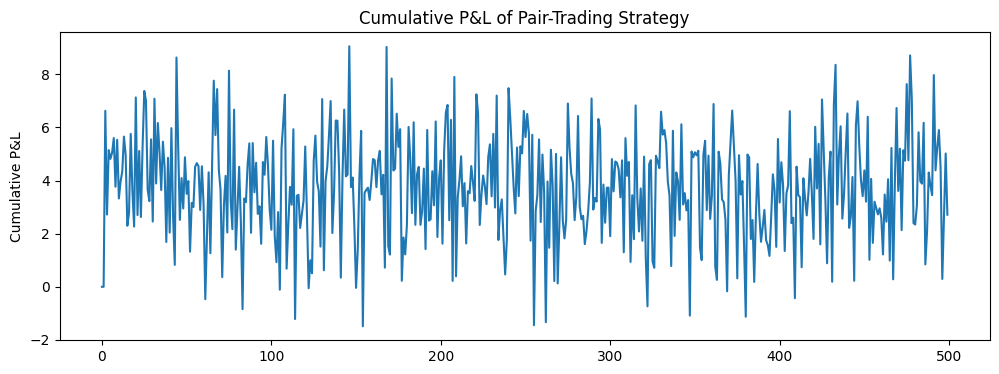

In [6]:
df['spread_diff'] = df['spread'].diff()
df['pnl'] = df['position'].shift(1) * df['spread_diff']
df['cum_pnl'] = df['pnl'].cumsum().fillna(0)

plt.figure(figsize=(12,4))
df['cum_pnl'].plot(title='Cumulative P&L of Pair-Trading Strategy')
plt.ylabel('Cumulative P&L')
plt.show()

### Summary of Results
- **p-value** of cointegration test: indicates whether the series are statistically cointegrated.  
- **Hedge ratio** β̂: how much of S1 to hold against S2.  
- **Strategy P&L**: cumulative profit or loss over the test period.